In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.utils import shuffle

! pip install openpyxl

In [91]:
all_df = pd.read_excel('Real_estate_valuation_data_set.xlsx',index_col=False)
all_df = shuffle(all_df)
all_df

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
279,280,2013.416667,2.6,1554.25000,3,24.97026,121.51642,31.1
92,93,2012.916667,20.6,2469.64500,4,24.96108,121.51046,21.8
275,276,2012.666667,1.5,23.38284,7,24.96772,121.54102,49.7
391,392,2013.583333,6.2,1939.74900,1,24.95155,121.55387,31.3
157,158,2013.250000,16.1,815.93140,4,24.97886,121.53464,35.6
...,...,...,...,...,...,...,...,...
261,262,2013.166667,16.2,2288.01100,3,24.95885,121.51359,24.4
365,366,2012.916667,17.3,2261.43200,4,24.96182,121.51222,29.5
260,261,2013.250000,17.0,1485.09700,4,24.97073,121.51700,30.7
177,178,2013.083333,33.0,181.07660,9,24.97697,121.54262,42.0


In [92]:
all_df.info()
all_df = all_df.drop("No",axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 279 to 127
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 29.1 KB


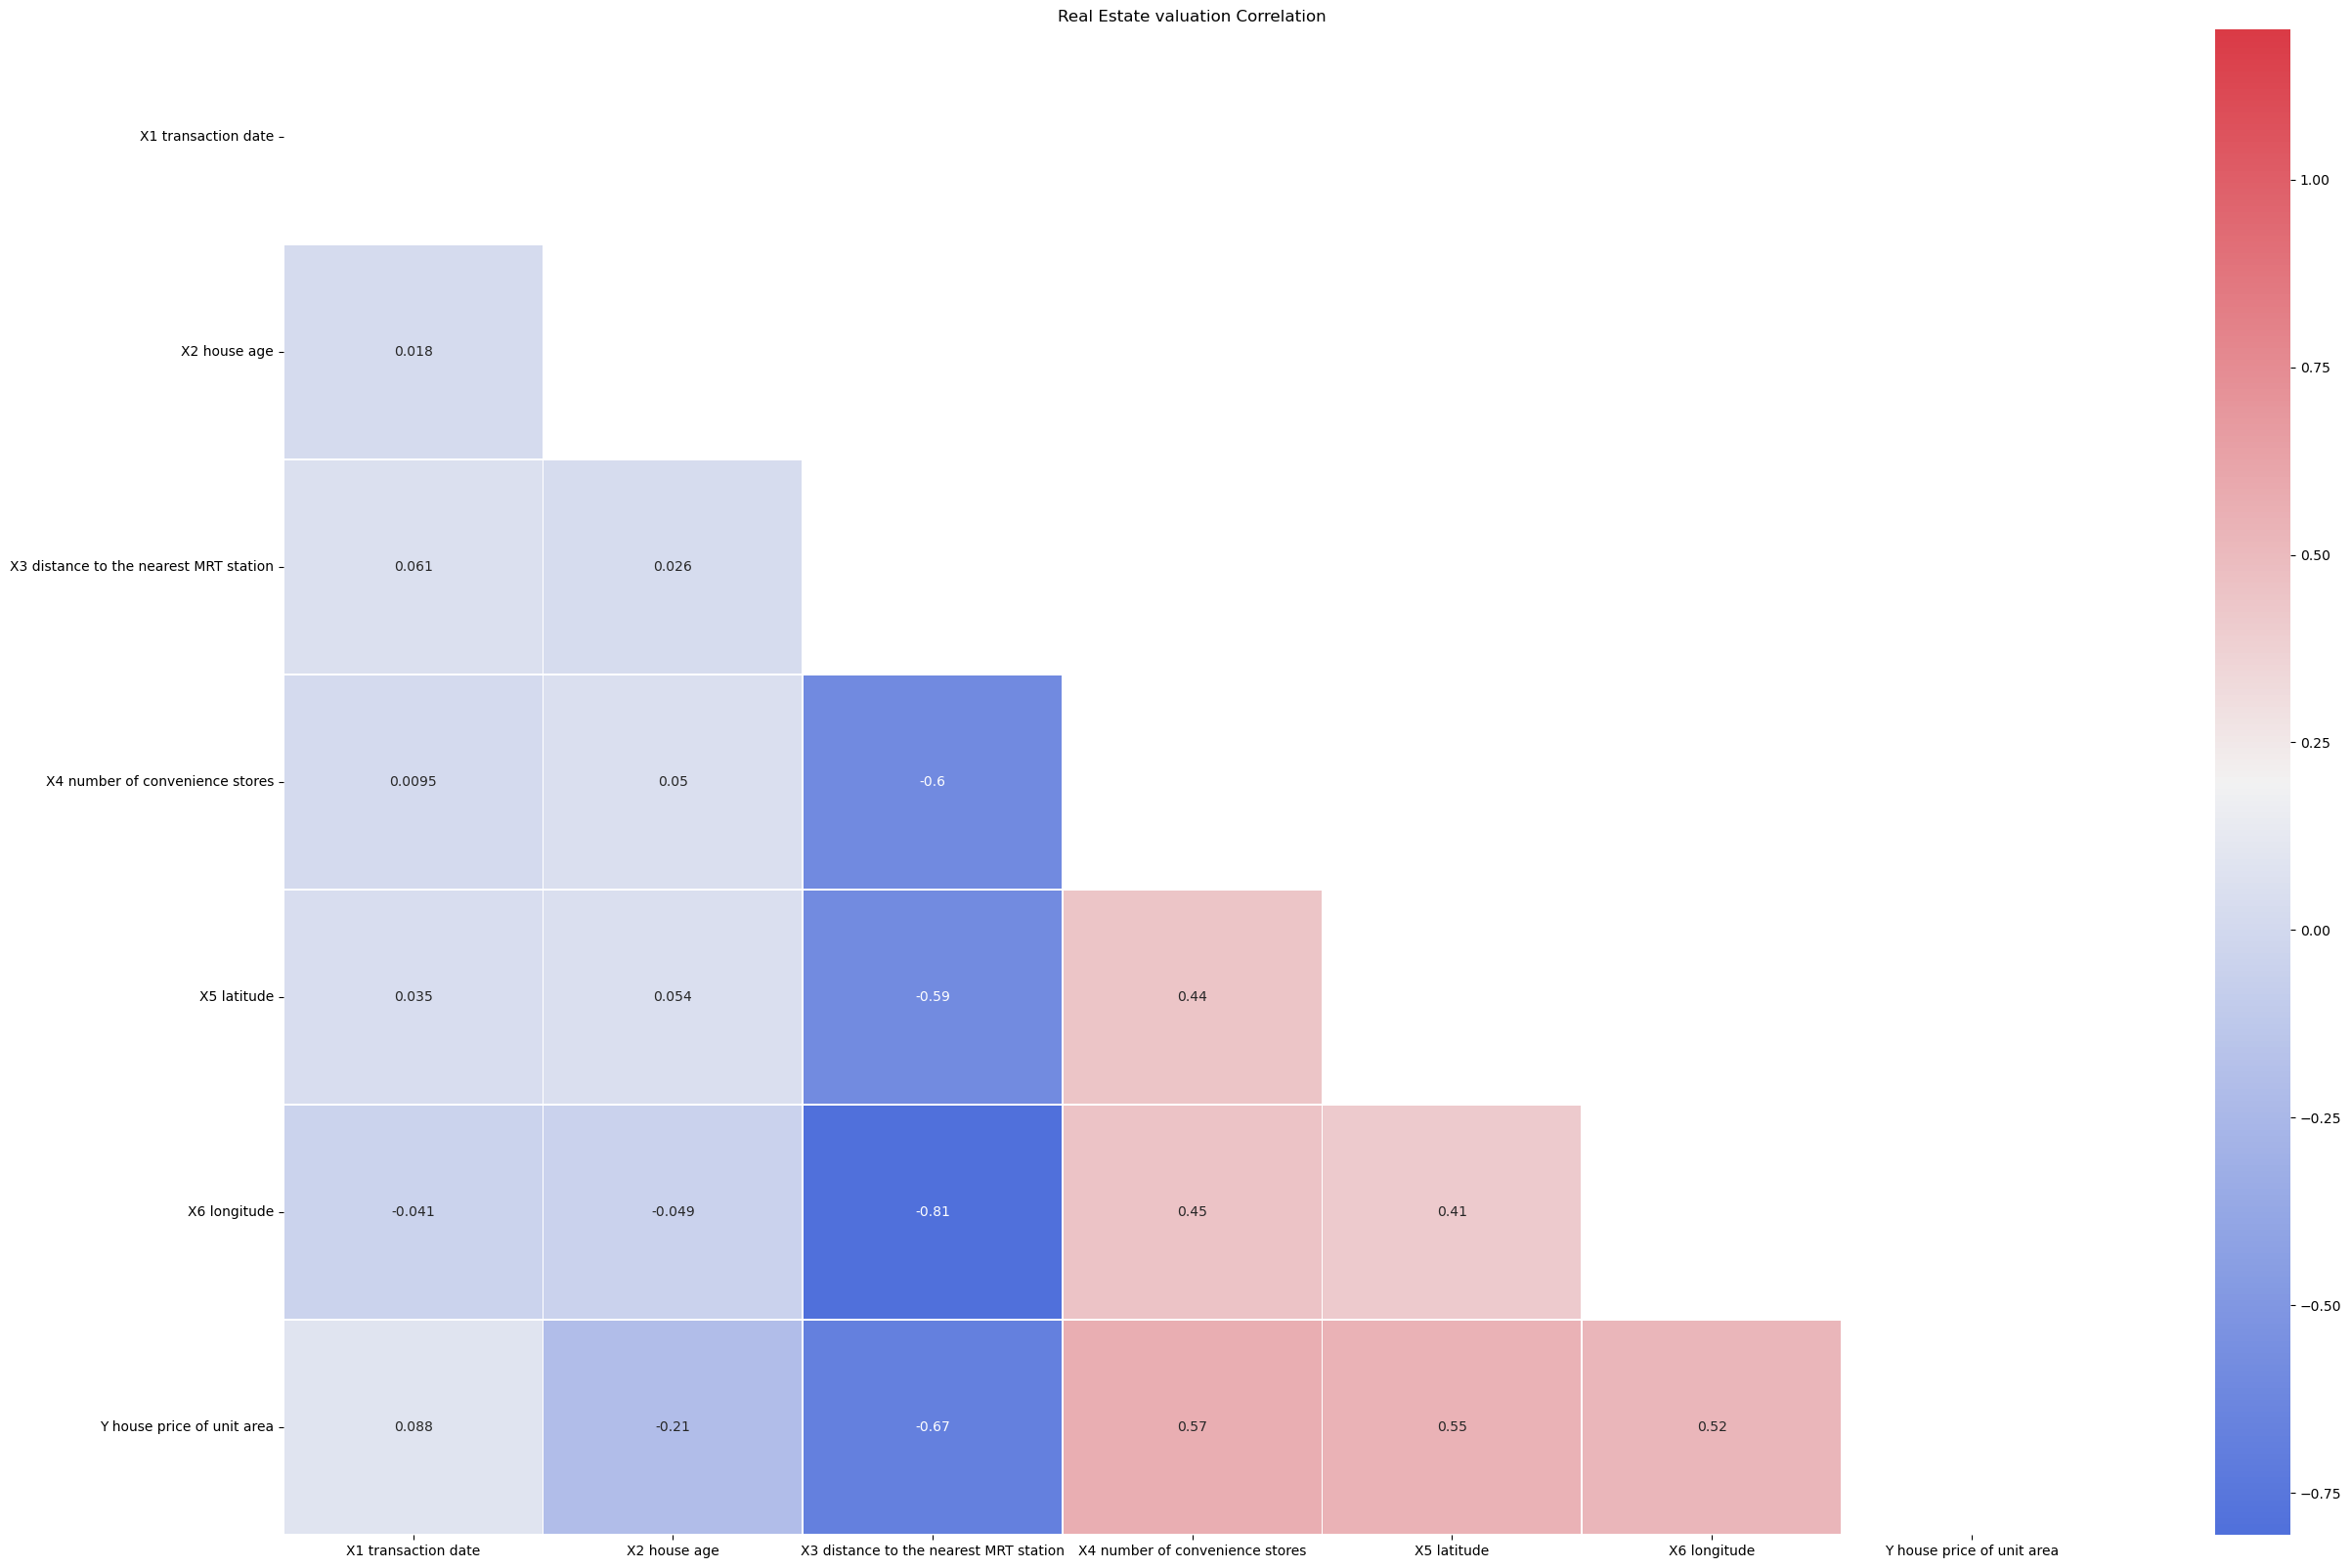

In [93]:
corrMatt = all_df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(30, 20))
plt.title('Real Estate valuation Correlation')
# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatt, vmax=1.2, square=False, cmap=cmap, mask=mask, ax=ax, annot=True, fmt='.2g', linewidths=0.5);

In [94]:
Xs = all_df.drop("Y house price of unit area",axis=1)
target = all_df['Y house price of unit area']

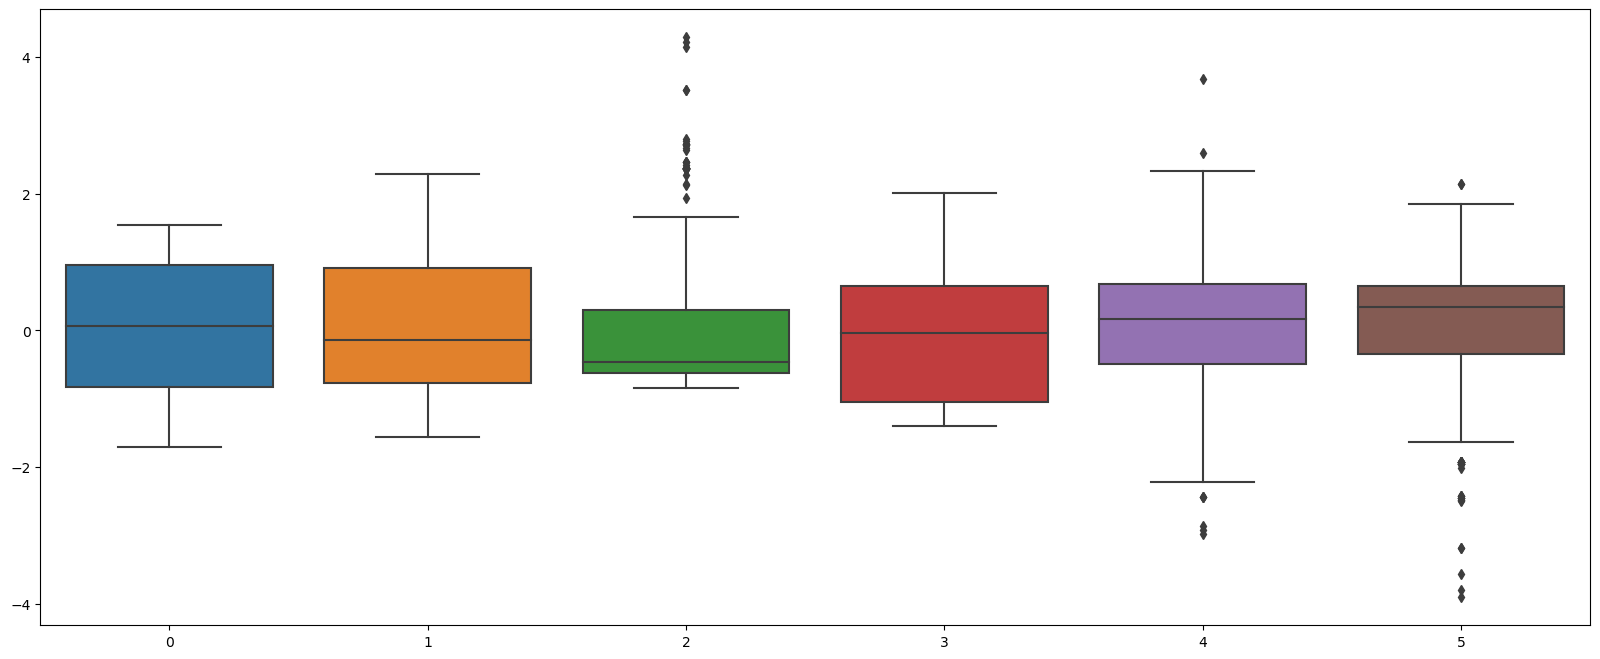

In [95]:
scaler = StandardScaler()
features = scaler.fit_transform(Xs)
fig,ax=plt.subplots(1,figsize=(20,8))
sns.boxplot(data=features,ax=ax)

In [96]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

In [97]:
#define currency conversion
def curr_conversion(score):
    result = np.sqrt(score)
    result = result/3.3
    result = result/37
    return result

### 2. Linear Regression

In [98]:
from sklearn.linear_model import LinearRegression

clf = LinearRegression()
cv_error = np.average(cross_val_score(clf, features, target, scoring = 'neg_mean_absolute_error')) * (-1)
print('The {}-fold cross-validation MSE score for this classifier is {:.2f}'.format(5, cv_error))

The 5-fold cross-validation MSE score for this classifier is 6.26


In [99]:
print('10000 NTD per Ping converted into 10000 GBD per meter squared :{:.5f}'.format(curr_conversion(cv_error)))

10000 NTD per Ping converted into 10000 GBD per meter squared :0.02049


### 3. SVM

In [100]:
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold

svm = SVR(kernel="rbf", gamma='auto')

In [101]:
cv_error_array = cross_val_score(svm, features, target,scoring='neg_mean_absolute_error') * (-1)
average = np.average(cv_error_array)
print('The {}-fold cross-validation accuracy score for this classifier is {:.2f}'.format(5, average))

The 5-fold cross-validation accuracy score for this classifier is 5.95


In [102]:
from sklearn.metrics import mean_squared_error
y_true = [30, 40]
y_pred = [50, 60]
mean_squared_error(y_true, y_pred, squared=True)

400.0

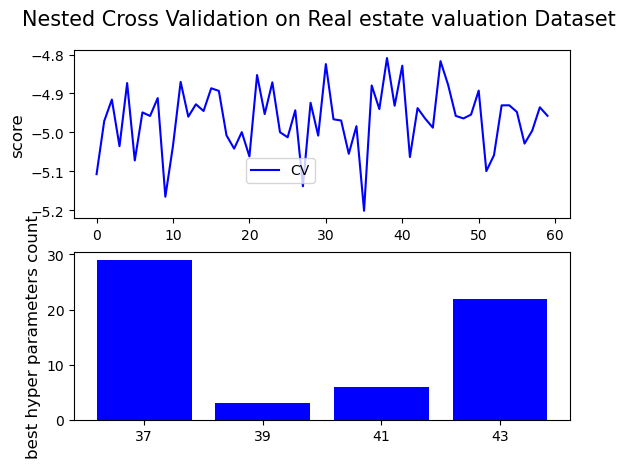

In [103]:
NUM_TRIALS = 60
X = features
y = target

# Set up possible values of parameters to optimize over
p_grid = {"C": [37,39,41,43]}

scores = np.zeros(NUM_TRIALS)
params = []

for i in range(NUM_TRIALS):

    cv = KFold(n_splits=5, shuffle=True, random_state=i)
    
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=cv, scoring='neg_mean_absolute_error')
    clf.fit(X,y)
    scores[i] = clf.best_score_
    params.append(clf.best_params_)


best_hyper_params_count = np.zeros(4)
for i in params:
    if params.count(i) >= 1:
        best_hyper_params_count[int((i["C"]-37)/2)] = params.count(i)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
(line,) = plt.plot(scores, color="b")
plt.ylabel("score", fontsize="12")
plt.legend(
    [line],
    ["CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Nested Cross Validation on Real estate valuation Dataset ",
    x=0.5,
    y=1.1,
    fontsize="15",
)

plt.subplot(212)

plt.bar(range(len(best_hyper_params_count)), best_hyper_params_count,fc='b', tick_label=[37,39,41,43])
plt.ylabel("best hyper parameters count", fontsize="12")
plt.show()

In [104]:
svm = SVR(C = 37,kernel="rbf", gamma='auto')
cv_error_array = cross_val_score(svm, features, target,scoring='neg_mean_absolute_error') * (-1)
average = np.average(cv_error_array)
print('The {}-fold cross-validation MSE score for this classifier is {:.2f}'.format(5, average))

The 5-fold cross-validation MSE score for this classifier is 5.01


In [105]:
print('10000 NTD per Ping converted into 10000 GBD per meter squared :{:.5f}'.format(curr_conversion(average)))

10000 NTD per Ping converted into 10000 GBD per meter squared :0.01834


### 4. Decision Tree

In [106]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [107]:
tree_dtr = tree.DecisionTreeRegressor()

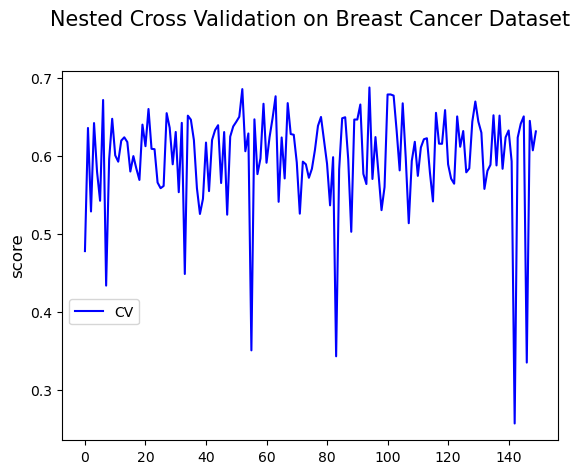

In [108]:
from sklearn.model_selection import KFold

NUM_TRIALS = 150

X = features
y = target

p_grid = {'max_depth': [3, 5, 7, 9, 11], 'min_samples_split':[5, 10, 15]}
scores = np.zeros(NUM_TRIALS)
params = []
for i in range(NUM_TRIALS):

    cv = KFold(n_splits=5, shuffle=True, random_state=i)

    dtr = GridSearchCV(estimator=tree_dtr, param_grid=p_grid, cv=cv)
    dtr.fit(X,y)
    scores[i] = dtr.best_score_
    params.append(dtr.best_params_)
    best_hyper_params_count = [[0 for i in range(5)] for j in range(3)]
    
for i in params:
    best_hyper_params_count[int(i['min_samples_split']/5-1)][int((i['max_depth']-3)/2)] = params.count(i)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
(line,) = plt.plot(scores, color="b")
plt.ylabel("score", fontsize="12")
plt.legend(
    [line],
    ["CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Nested Cross Validation on Breast Cancer Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

plt.show()

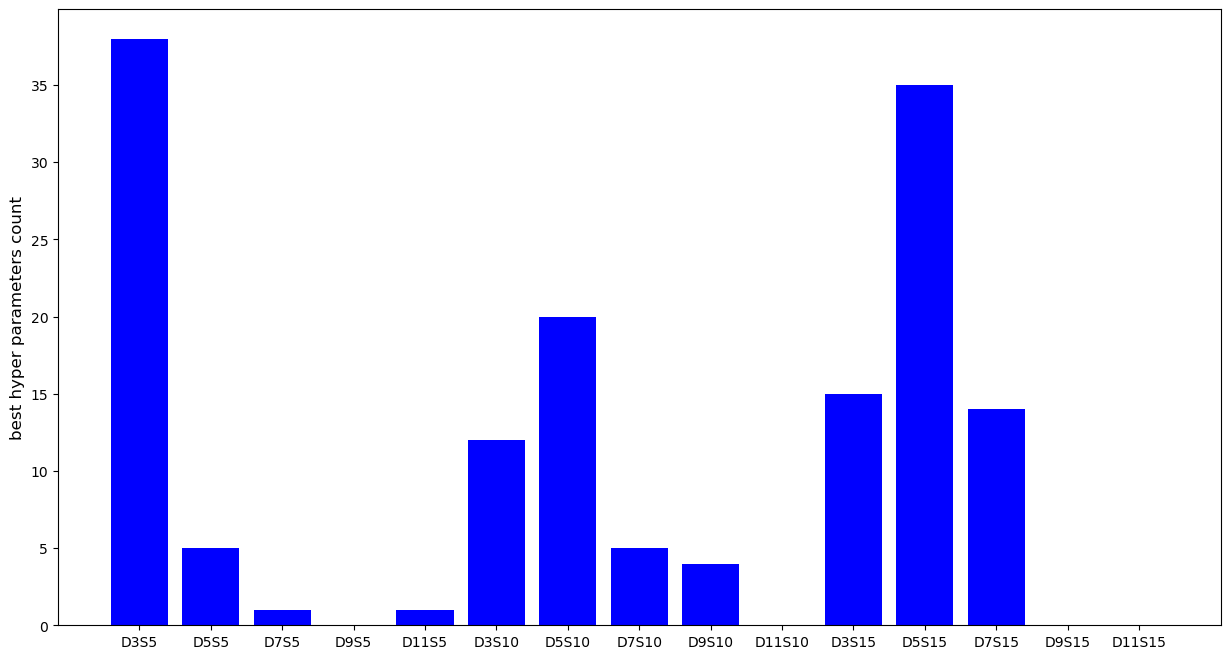

In [109]:
plt.figure(figsize = (15,8))

whole_list = best_hyper_params_count[0] + best_hyper_params_count[1] + best_hyper_params_count[2]

lang = []

for j in range(5,20,5):
    for i in range(3,13,2):
        lang.append('D' + str(i) + 'S' + str(j))       

plt.bar(range(len(whole_list)), whole_list, fc='b', tick_label=lang)

plt.ylabel("best hyper parameters count", fontsize="12")

plt.show()

In [110]:
tree_reg = DecisionTreeRegressor(max_depth = 3, min_samples_split = 5)

cv_error_array = cross_val_score(tree_reg, features, target, scoring='neg_mean_absolute_error') * (-1)

average = np.average(cv_error_array)

print('The {}-fold cross-validation MSE score for this classifier is {:.2f}'.format(5, average))

The 5-fold cross-validation MSE score for this classifier is 5.91


In [111]:
print('10000 NTD per Ping converted into 10000 GBD per meter squared :{:.5f}'.format(curr_conversion(average)))

10000 NTD per Ping converted into 10000 GBD per meter squared :0.01991


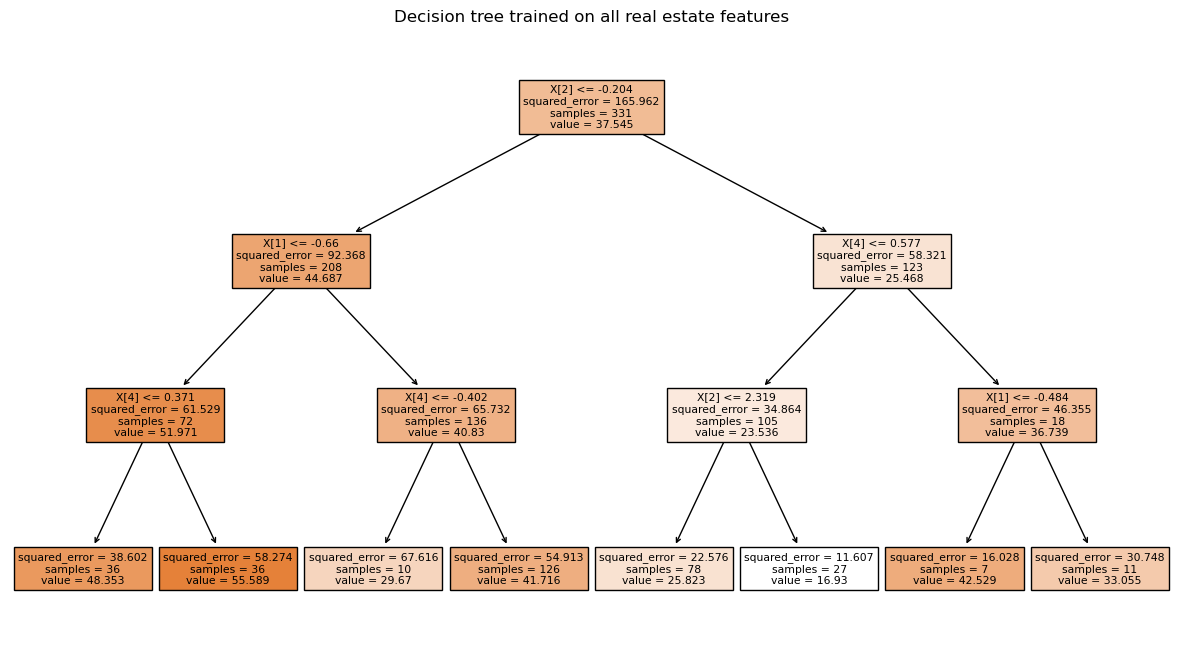

In [112]:
from sklearn.tree import plot_tree

plt.figure(figsize = (15,8))
plot_tree(tree_reg.fit(x_train, y_train), filled=True)
plt.title("Decision tree trained on all real estate features")
plt.show()

### 5. ANN

In [113]:
from tensorflow import keras

model = keras.models.Sequential()  
model.add(keras.layers.Dense(units = 8, activation='relu', input_shape=(x_train.shape[1],)))
    
model.add(keras.layers.Dense(units = 1, activation='linear'))  
    
print(model.summary())  
    
model.compile(loss='mse',optimizer='sgd',  metrics=[keras.metrics.MeanSquaredError()])  

kf = KFold(n_splits=5)
k=1
    
all_score = []

for train_index, test_index in kf.split(features):
    print("fold",k)
    # Split the data
    X_train, X_test = np.array(features)[train_index], np.array(features)[test_index]
    y_train, y_test = np.array(target)[train_index], np.array(target)[test_index]
        
    # training and validation
    model.fit(np.array(X_train), np.array(y_train), epochs=200, batch_size=200, verbose=2, validation_data=(np.array(X_test), np.array(y_test)))

    # evaluate the accuracy of each fold
    scores = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
    
    print("%s: %.2f" % (model.metrics_names[1], scores[1]))
    k = k+1
    all_score.append(scores[1])


Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_150 (Dense)            (None, 8)                 56        
_________________________________________________________________
dense_151 (Dense)            (None, 1)                 9         
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________
None
fold 1
Train on 331 samples, validate on 83 samples
Epoch 1/200
331/331 - 1s - loss: 1486.0180 - mean_squared_error: 1486.0179 - val_loss: 1432.1683 - val_mean_squared_error: 1432.1683
Epoch 2/200
331/331 - 0s - loss: 1089.4308 - mean_squared_error: 1089.4308 - val_loss: 467.6230 - val_mean_squared_error: 467.6230
Epoch 3/200
331/331 - 0s - loss: 259.5305 - mean_squared_error: 259.5305 - val_loss: 105.0220 - val_mean_squared_error: 105.0220
Epoch 4/200
331/331 - 0s - loss: 89.4168 - mean_squared_error: 89.416

Epoch 61/200
331/331 - 0s - loss: 61.1676 - mean_squared_error: 61.1676 - val_loss: 76.4879 - val_mean_squared_error: 76.4879
Epoch 62/200
331/331 - 0s - loss: 60.4536 - mean_squared_error: 60.4536 - val_loss: 80.2759 - val_mean_squared_error: 80.2759
Epoch 63/200
331/331 - 0s - loss: 62.2177 - mean_squared_error: 62.2177 - val_loss: 85.1856 - val_mean_squared_error: 85.1856
Epoch 64/200
331/331 - 0s - loss: 60.2415 - mean_squared_error: 60.2415 - val_loss: 65.1871 - val_mean_squared_error: 65.1871
Epoch 65/200
331/331 - 0s - loss: 61.4289 - mean_squared_error: 61.4288 - val_loss: 69.1595 - val_mean_squared_error: 69.1595
Epoch 66/200
331/331 - 0s - loss: 62.8335 - mean_squared_error: 62.8335 - val_loss: 66.6002 - val_mean_squared_error: 66.6002
Epoch 67/200
331/331 - 0s - loss: 60.7654 - mean_squared_error: 60.7654 - val_loss: 68.7734 - val_mean_squared_error: 68.7734
Epoch 68/200
331/331 - 0s - loss: 59.6742 - mean_squared_error: 59.6742 - val_loss: 63.3041 - val_mean_squared_error: 

Epoch 126/200
331/331 - 0s - loss: 56.5737 - mean_squared_error: 56.5737 - val_loss: 64.8931 - val_mean_squared_error: 64.8931
Epoch 127/200
331/331 - 0s - loss: 55.7431 - mean_squared_error: 55.7431 - val_loss: 63.5834 - val_mean_squared_error: 63.5834
Epoch 128/200
331/331 - 0s - loss: 55.4139 - mean_squared_error: 55.4139 - val_loss: 67.4974 - val_mean_squared_error: 67.4974
Epoch 129/200
331/331 - 0s - loss: 56.1221 - mean_squared_error: 56.1221 - val_loss: 59.0982 - val_mean_squared_error: 59.0982
Epoch 130/200
331/331 - 0s - loss: 56.3202 - mean_squared_error: 56.3202 - val_loss: 67.5038 - val_mean_squared_error: 67.5038
Epoch 131/200
331/331 - 0s - loss: 55.8123 - mean_squared_error: 55.8123 - val_loss: 64.1534 - val_mean_squared_error: 64.1534
Epoch 132/200
331/331 - 0s - loss: 56.0513 - mean_squared_error: 56.0513 - val_loss: 77.4899 - val_mean_squared_error: 77.4899
Epoch 133/200
331/331 - 0s - loss: 56.8432 - mean_squared_error: 56.8432 - val_loss: 69.3231 - val_mean_squared

Epoch 191/200
331/331 - 0s - loss: 51.9718 - mean_squared_error: 51.9718 - val_loss: 61.2018 - val_mean_squared_error: 61.2018
Epoch 192/200
331/331 - 0s - loss: 51.5288 - mean_squared_error: 51.5288 - val_loss: 66.1202 - val_mean_squared_error: 66.1202
Epoch 193/200
331/331 - 0s - loss: 52.5795 - mean_squared_error: 52.5795 - val_loss: 69.8628 - val_mean_squared_error: 69.8628
Epoch 194/200
331/331 - 0s - loss: 52.8185 - mean_squared_error: 52.8185 - val_loss: 65.0721 - val_mean_squared_error: 65.0721
Epoch 195/200
331/331 - 0s - loss: 51.9665 - mean_squared_error: 51.9665 - val_loss: 65.6819 - val_mean_squared_error: 65.6819
Epoch 196/200
331/331 - 0s - loss: 51.9763 - mean_squared_error: 51.9763 - val_loss: 66.0616 - val_mean_squared_error: 66.0616
Epoch 197/200
331/331 - 0s - loss: 52.5804 - mean_squared_error: 52.5804 - val_loss: 70.8765 - val_mean_squared_error: 70.8765
Epoch 198/200
331/331 - 0s - loss: 52.5431 - mean_squared_error: 52.5431 - val_loss: 62.1751 - val_mean_squared

Epoch 55/200
331/331 - 0s - loss: 41.7256 - mean_squared_error: 41.7256 - val_loss: 105.7611 - val_mean_squared_error: 105.7611
Epoch 56/200
331/331 - 0s - loss: 38.9987 - mean_squared_error: 38.9987 - val_loss: 105.7725 - val_mean_squared_error: 105.7725
Epoch 57/200
331/331 - 0s - loss: 39.0560 - mean_squared_error: 39.0560 - val_loss: 107.7617 - val_mean_squared_error: 107.7617
Epoch 58/200
331/331 - 0s - loss: 40.4890 - mean_squared_error: 40.4890 - val_loss: 103.4557 - val_mean_squared_error: 103.4557
Epoch 59/200
331/331 - 0s - loss: 41.4675 - mean_squared_error: 41.4675 - val_loss: 108.9532 - val_mean_squared_error: 108.9532
Epoch 60/200
331/331 - 0s - loss: 40.8814 - mean_squared_error: 40.8814 - val_loss: 105.6851 - val_mean_squared_error: 105.6851
Epoch 61/200
331/331 - 0s - loss: 40.9360 - mean_squared_error: 40.9360 - val_loss: 109.1476 - val_mean_squared_error: 109.1476
Epoch 62/200
331/331 - 0s - loss: 39.9630 - mean_squared_error: 39.9630 - val_loss: 110.4000 - val_mean_

Epoch 119/200
331/331 - 0s - loss: 42.5632 - mean_squared_error: 42.5632 - val_loss: 111.3259 - val_mean_squared_error: 111.3259
Epoch 120/200
331/331 - 0s - loss: 47.0814 - mean_squared_error: 47.0814 - val_loss: 115.8383 - val_mean_squared_error: 115.8383
Epoch 121/200
331/331 - 0s - loss: 39.6432 - mean_squared_error: 39.6432 - val_loss: 111.1121 - val_mean_squared_error: 111.1121
Epoch 122/200
331/331 - 0s - loss: 44.1754 - mean_squared_error: 44.1754 - val_loss: 113.5531 - val_mean_squared_error: 113.5531
Epoch 123/200
331/331 - 0s - loss: 42.4424 - mean_squared_error: 42.4424 - val_loss: 105.9220 - val_mean_squared_error: 105.9220
Epoch 124/200
331/331 - 0s - loss: 39.5879 - mean_squared_error: 39.5879 - val_loss: 105.5306 - val_mean_squared_error: 105.5306
Epoch 125/200
331/331 - 0s - loss: 38.1926 - mean_squared_error: 38.1926 - val_loss: 104.8937 - val_mean_squared_error: 104.8937
Epoch 126/200
331/331 - 0s - loss: 38.2766 - mean_squared_error: 38.2766 - val_loss: 106.4393 - v

Epoch 183/200
331/331 - 0s - loss: 39.4775 - mean_squared_error: 39.4775 - val_loss: 103.2437 - val_mean_squared_error: 103.2437
Epoch 184/200
331/331 - 0s - loss: 37.9701 - mean_squared_error: 37.9701 - val_loss: 105.0297 - val_mean_squared_error: 105.0297
Epoch 185/200
331/331 - 0s - loss: 37.5468 - mean_squared_error: 37.5468 - val_loss: 103.8126 - val_mean_squared_error: 103.8126
Epoch 186/200
331/331 - 0s - loss: 38.7687 - mean_squared_error: 38.7687 - val_loss: 108.1801 - val_mean_squared_error: 108.1801
Epoch 187/200
331/331 - 0s - loss: 45.8522 - mean_squared_error: 45.8522 - val_loss: 111.0762 - val_mean_squared_error: 111.0762
Epoch 188/200
331/331 - 0s - loss: 40.8885 - mean_squared_error: 40.8885 - val_loss: 102.3269 - val_mean_squared_error: 102.3269
Epoch 189/200
331/331 - 0s - loss: 37.7298 - mean_squared_error: 37.7298 - val_loss: 103.6429 - val_mean_squared_error: 103.6429
Epoch 190/200
331/331 - 0s - loss: 37.2332 - mean_squared_error: 37.2332 - val_loss: 104.3560 - v

Epoch 48/200
331/331 - 0s - loss: 55.0270 - mean_squared_error: 55.0270 - val_loss: 45.7366 - val_mean_squared_error: 45.7366
Epoch 49/200
331/331 - 0s - loss: 52.1685 - mean_squared_error: 52.1685 - val_loss: 44.3103 - val_mean_squared_error: 44.3103
Epoch 50/200
331/331 - 0s - loss: 50.8639 - mean_squared_error: 50.8639 - val_loss: 45.5095 - val_mean_squared_error: 45.5095
Epoch 51/200
331/331 - 0s - loss: 51.3165 - mean_squared_error: 51.3165 - val_loss: 45.8205 - val_mean_squared_error: 45.8205
Epoch 52/200
331/331 - 0s - loss: 52.6885 - mean_squared_error: 52.6885 - val_loss: 48.9396 - val_mean_squared_error: 48.9396
Epoch 53/200
331/331 - 0s - loss: 54.3489 - mean_squared_error: 54.3489 - val_loss: 49.3603 - val_mean_squared_error: 49.3603
Epoch 54/200
331/331 - 0s - loss: 51.9165 - mean_squared_error: 51.9165 - val_loss: 45.1651 - val_mean_squared_error: 45.1651
Epoch 55/200
331/331 - 0s - loss: 52.1226 - mean_squared_error: 52.1226 - val_loss: 45.4371 - val_mean_squared_error: 

Epoch 113/200
331/331 - 0s - loss: 51.9613 - mean_squared_error: 51.9613 - val_loss: 47.1660 - val_mean_squared_error: 47.1660
Epoch 114/200
331/331 - 0s - loss: 50.6680 - mean_squared_error: 50.6680 - val_loss: 47.5313 - val_mean_squared_error: 47.5313
Epoch 115/200
331/331 - 0s - loss: 51.1012 - mean_squared_error: 51.1012 - val_loss: 45.2119 - val_mean_squared_error: 45.2119
Epoch 116/200
331/331 - 0s - loss: 54.6031 - mean_squared_error: 54.6031 - val_loss: 55.9519 - val_mean_squared_error: 55.9519
Epoch 117/200
331/331 - 0s - loss: 57.7944 - mean_squared_error: 57.7944 - val_loss: 47.0701 - val_mean_squared_error: 47.0701
Epoch 118/200
331/331 - 0s - loss: 53.1134 - mean_squared_error: 53.1134 - val_loss: 47.4009 - val_mean_squared_error: 47.4009
Epoch 119/200
331/331 - 0s - loss: 51.9962 - mean_squared_error: 51.9962 - val_loss: 45.3177 - val_mean_squared_error: 45.3177
Epoch 120/200
331/331 - 0s - loss: 50.9889 - mean_squared_error: 50.9889 - val_loss: 47.0146 - val_mean_squared

Epoch 178/200
331/331 - 0s - loss: 52.0441 - mean_squared_error: 52.0441 - val_loss: 46.5168 - val_mean_squared_error: 46.5168
Epoch 179/200
331/331 - 0s - loss: 50.5654 - mean_squared_error: 50.5654 - val_loss: 48.1561 - val_mean_squared_error: 48.1561
Epoch 180/200
331/331 - 0s - loss: 50.9885 - mean_squared_error: 50.9885 - val_loss: 44.8514 - val_mean_squared_error: 44.8514
Epoch 181/200
331/331 - 0s - loss: 50.3507 - mean_squared_error: 50.3507 - val_loss: 46.5143 - val_mean_squared_error: 46.5143
Epoch 182/200
331/331 - 0s - loss: 52.5803 - mean_squared_error: 52.5803 - val_loss: 47.4537 - val_mean_squared_error: 47.4537
Epoch 183/200
331/331 - 0s - loss: 52.9654 - mean_squared_error: 52.9654 - val_loss: 46.5421 - val_mean_squared_error: 46.5421
Epoch 184/200
331/331 - 0s - loss: 50.5808 - mean_squared_error: 50.5808 - val_loss: 46.4369 - val_mean_squared_error: 46.4369
Epoch 185/200
331/331 - 0s - loss: 50.4493 - mean_squared_error: 50.4493 - val_loss: 46.8045 - val_mean_squared

Epoch 43/200
331/331 - 0s - loss: 59.0286 - mean_squared_error: 59.0286 - val_loss: 35.7712 - val_mean_squared_error: 35.7712
Epoch 44/200
331/331 - 0s - loss: 59.7291 - mean_squared_error: 59.7291 - val_loss: 33.9574 - val_mean_squared_error: 33.9574
Epoch 45/200
331/331 - 0s - loss: 53.4329 - mean_squared_error: 53.4329 - val_loss: 35.2884 - val_mean_squared_error: 35.2884
Epoch 46/200
331/331 - 0s - loss: 52.2409 - mean_squared_error: 52.2409 - val_loss: 33.6394 - val_mean_squared_error: 33.6394
Epoch 47/200
331/331 - 0s - loss: 54.1806 - mean_squared_error: 54.1805 - val_loss: 33.7076 - val_mean_squared_error: 33.7076
Epoch 48/200
331/331 - 0s - loss: 53.7189 - mean_squared_error: 53.7189 - val_loss: 36.9382 - val_mean_squared_error: 36.9382
Epoch 49/200
331/331 - 0s - loss: 52.3780 - mean_squared_error: 52.3780 - val_loss: 35.3032 - val_mean_squared_error: 35.3032
Epoch 50/200
331/331 - 0s - loss: 51.9342 - mean_squared_error: 51.9342 - val_loss: 33.5360 - val_mean_squared_error: 

Epoch 108/200
331/331 - 0s - loss: 53.3685 - mean_squared_error: 53.3685 - val_loss: 34.0348 - val_mean_squared_error: 34.0348
Epoch 109/200
331/331 - 0s - loss: 52.4763 - mean_squared_error: 52.4763 - val_loss: 33.2926 - val_mean_squared_error: 33.2926
Epoch 110/200
331/331 - 0s - loss: 54.4793 - mean_squared_error: 54.4793 - val_loss: 34.8871 - val_mean_squared_error: 34.8871
Epoch 111/200
331/331 - 0s - loss: 55.9116 - mean_squared_error: 55.9116 - val_loss: 36.2147 - val_mean_squared_error: 36.2147
Epoch 112/200
331/331 - 0s - loss: 60.4666 - mean_squared_error: 60.4666 - val_loss: 37.6436 - val_mean_squared_error: 37.6436
Epoch 113/200
331/331 - 0s - loss: 61.2041 - mean_squared_error: 61.2041 - val_loss: 35.0235 - val_mean_squared_error: 35.0235
Epoch 114/200
331/331 - 0s - loss: 52.7461 - mean_squared_error: 52.7461 - val_loss: 43.4278 - val_mean_squared_error: 43.4278
Epoch 115/200
331/331 - 0s - loss: 65.6108 - mean_squared_error: 65.6108 - val_loss: 56.2929 - val_mean_squared

Epoch 173/200
331/331 - 0s - loss: 52.8975 - mean_squared_error: 52.8975 - val_loss: 34.5679 - val_mean_squared_error: 34.5679
Epoch 174/200
331/331 - 0s - loss: 51.1171 - mean_squared_error: 51.1171 - val_loss: 35.2300 - val_mean_squared_error: 35.2300
Epoch 175/200
331/331 - 0s - loss: 51.9652 - mean_squared_error: 51.9652 - val_loss: 35.1116 - val_mean_squared_error: 35.1116
Epoch 176/200
331/331 - 0s - loss: 54.1387 - mean_squared_error: 54.1387 - val_loss: 38.0460 - val_mean_squared_error: 38.0460
Epoch 177/200
331/331 - 0s - loss: 65.0364 - mean_squared_error: 65.0364 - val_loss: 42.6926 - val_mean_squared_error: 42.6926
Epoch 178/200
331/331 - 0s - loss: 63.9598 - mean_squared_error: 63.9598 - val_loss: 33.7800 - val_mean_squared_error: 33.7800
Epoch 179/200
331/331 - 0s - loss: 53.1652 - mean_squared_error: 53.1652 - val_loss: 34.5929 - val_mean_squared_error: 34.5929
Epoch 180/200
331/331 - 0s - loss: 57.0683 - mean_squared_error: 57.0683 - val_loss: 39.9452 - val_mean_squared

Epoch 38/200
332/332 - 0s - loss: 52.1529 - mean_squared_error: 52.1529 - val_loss: 41.7968 - val_mean_squared_error: 41.7968
Epoch 39/200
332/332 - 0s - loss: 50.6537 - mean_squared_error: 50.6537 - val_loss: 42.8503 - val_mean_squared_error: 42.8503
Epoch 40/200
332/332 - 0s - loss: 54.5242 - mean_squared_error: 54.5242 - val_loss: 60.2281 - val_mean_squared_error: 60.2281
Epoch 41/200
332/332 - 0s - loss: 57.6046 - mean_squared_error: 57.6046 - val_loss: 45.4265 - val_mean_squared_error: 45.4265
Epoch 42/200
332/332 - 0s - loss: 53.3625 - mean_squared_error: 53.3625 - val_loss: 49.3714 - val_mean_squared_error: 49.3714
Epoch 43/200
332/332 - 0s - loss: 54.9342 - mean_squared_error: 54.9342 - val_loss: 49.9248 - val_mean_squared_error: 49.9248
Epoch 44/200
332/332 - 0s - loss: 56.3312 - mean_squared_error: 56.3312 - val_loss: 58.3862 - val_mean_squared_error: 58.3862
Epoch 45/200
332/332 - 0s - loss: 55.7671 - mean_squared_error: 55.7671 - val_loss: 39.9322 - val_mean_squared_error: 

Epoch 103/200
332/332 - 0s - loss: 51.5073 - mean_squared_error: 51.5073 - val_loss: 43.4149 - val_mean_squared_error: 43.4149
Epoch 104/200
332/332 - 0s - loss: 52.1641 - mean_squared_error: 52.1641 - val_loss: 41.0871 - val_mean_squared_error: 41.0871
Epoch 105/200
332/332 - 0s - loss: 50.7742 - mean_squared_error: 50.7742 - val_loss: 43.5738 - val_mean_squared_error: 43.5738
Epoch 106/200
332/332 - 0s - loss: 49.5096 - mean_squared_error: 49.5096 - val_loss: 41.0093 - val_mean_squared_error: 41.0093
Epoch 107/200
332/332 - 0s - loss: 50.4374 - mean_squared_error: 50.4374 - val_loss: 45.0928 - val_mean_squared_error: 45.0928
Epoch 108/200
332/332 - 0s - loss: 52.2841 - mean_squared_error: 52.2841 - val_loss: 39.4140 - val_mean_squared_error: 39.4140
Epoch 109/200
332/332 - 0s - loss: 53.5360 - mean_squared_error: 53.5360 - val_loss: 41.0634 - val_mean_squared_error: 41.0634
Epoch 110/200
332/332 - 0s - loss: 51.1221 - mean_squared_error: 51.1221 - val_loss: 41.2362 - val_mean_squared

Epoch 168/200
332/332 - 0s - loss: 53.4060 - mean_squared_error: 53.4060 - val_loss: 57.9248 - val_mean_squared_error: 57.9248
Epoch 169/200
332/332 - 0s - loss: 57.0983 - mean_squared_error: 57.0983 - val_loss: 61.0432 - val_mean_squared_error: 61.0432
Epoch 170/200
332/332 - 0s - loss: 53.9428 - mean_squared_error: 53.9428 - val_loss: 50.8004 - val_mean_squared_error: 50.8004
Epoch 171/200
332/332 - 0s - loss: 50.0396 - mean_squared_error: 50.0396 - val_loss: 48.3257 - val_mean_squared_error: 48.3257
Epoch 172/200
332/332 - 0s - loss: 51.0951 - mean_squared_error: 51.0951 - val_loss: 52.2269 - val_mean_squared_error: 52.2269
Epoch 173/200
332/332 - 0s - loss: 54.1458 - mean_squared_error: 54.1458 - val_loss: 48.2195 - val_mean_squared_error: 48.2195
Epoch 174/200
332/332 - 0s - loss: 52.1731 - mean_squared_error: 52.1731 - val_loss: 48.1462 - val_mean_squared_error: 48.1462
Epoch 175/200
332/332 - 0s - loss: 50.2079 - mean_squared_error: 50.2078 - val_loss: 48.5630 - val_mean_squared

In [114]:
print(all_score)

[63.8688, 104.28238, 52.034897, 34.93914, 42.64078]


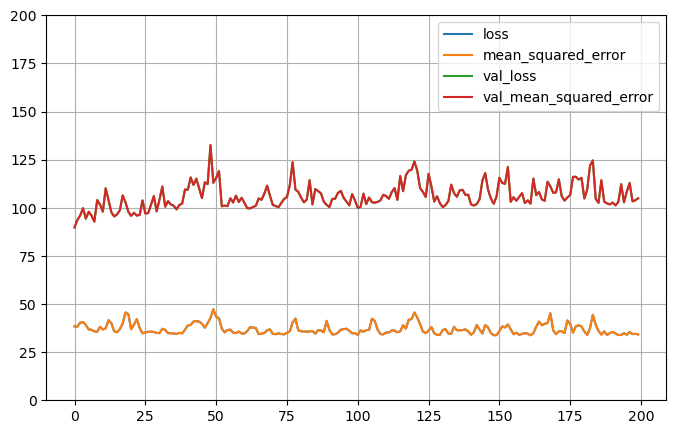

In [115]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

history = model.fit(x_train, y_train, epochs=200, batch_size=200, verbose=0, validation_data = (x_test, y_test))


pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 200) # set the vertical range to [0-1]
plt.show()